In [9]:
import pandas as pd
import statistics
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import warnings
import ast
warnings.filterwarnings('ignore')

In [139]:
PREFIX = '/home/gridsan/arunas/broca/'

og = pd.read_csv(f'{PREFIX}/data-gen/ngs.csv')
gCols = [col for col in og.columns if not 'ng-' in col]
f = pd.read_csv(f'/home/gridsan/arunas/broca/llama/experiments/llama-classification-train-test-det-{gCols[0]}.csv')
g = pd.read_csv('/home/gridsan/arunas/broca/llama/experiments/llama-classification-train-test-acc.csv')
for col in gCols[1:]:
    f = pd.concat([f, pd.read_csv(f'/home/gridsan/arunas/broca/llama/experiments/llama-classification-train-test-det-{col}.csv')])


In [ ]:
from matplotlib.pyplot import figure

figure(figsize=(10, 8), dpi=80)
x = list(range(12))
ifig,iax=plt.subplots(figsize=(20, 10))
jfig,jax=plt.subplots(figsize=(20, 10))
efig,eax=plt.subplots(figsize=(20, 10))

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
          '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf',
          '#ff00ff',
          '#00ffff', '#800000', '#008000', '#000080', '#808000',
          '#800080', '#008080', '#808080', '#c0c0c0', '#c0c0c0',
          '#00ffff', '#800000', '#008000', '#000080', '#808000',
          '#800080', '#008080', '#808080', '#c0c0c0', '#c0c0c0']
print(len(colors))
count = 0
for sent_type in sorted(f['type'].unique()):
    surps = []
    ng_surps = []
    for idx, row in f[(f['type'] == sent_type) & (f['gold'] == 'Yes')].iterrows():
        myList = []
        for i in list(ast.literal_eval(row['surprisal'])):
            myList.append(i[1])
        surps.append(myList)

    transformed_surps = np.array([list(zip(*surps))[i] for i in list(range(max([len(e) for e in surps])))])
    # print(transformed_surps)
    avg_surp = np.mean(transformed_surps, axis=1)

    font = {'family' : 'sans-serif',
            'weight' : 'normal',
            'size'   : 20}

    matplotlib.rc('font', **font)
    y = avg_surp.tolist()
    for i in range(len(y), len(x)): 
        y.append(np.nan)  # Adding missing values
    nan_indices = [index for index, value in enumerate(y) if np.isnan(value)]
    nan_x = [i for i in nan_indices]
    nan_y = [0 for i in nan_indices]
    # print(len(y), len(x), nan_indices)
    if 'it' in sent_type[:2]:
        if len(sent_type) > 3 and 'u' == sent_type[3]:
            iax.plot(x, y, '--', label=sent_type, linewidth=4, alpha=0.5, color=colors[count])
        else:
            iax.plot(x, y, label=sent_type, linewidth=4, alpha=0.5, color=colors[count])
    elif 'jp' in sent_type[:2]:
        if len(sent_type) > 3 and 'u' == sent_type[3]:
            jax.plot(x, y, '--', label=sent_type,linewidth=4, alpha=0.5, color=colors[count])
        else:
            jax.plot(x, y, label=sent_type, linewidth=4, alpha=0.5, color=colors[count])
    else:
        if len(sent_type) > 3 and 'u' == sent_type[3]:
            eax.plot(x, y, '--', label=sent_type, linewidth=4, alpha=0.5, color=colors[count])
        else:
            eax.plot(x, y, label=sent_type, linewidth=4, alpha=0.5, color=colors[count])

    for idx, row in f[(f['type'] == sent_type) & (f['gold'] == 'No')].iterrows():
        myList = []
        for i in list(ast.literal_eval(row['surprisal'])):
            myList.append(i[1])
        ng_surps.append(myList)

    

    transformed_ng_surps = np.array([list(zip(*ng_surps))[i] for i in list(range(max([len(e) for e in ng_surps])))])
    # print(transformed_ng_surps)
    avg_ng_surp = np.mean(transformed_ng_surps, axis=1)

    font = {'family' : 'sans-serif',
            'weight' : 'normal',
            'size'   : 20}

    matplotlib.rc('font', **font)
    y = avg_ng_surp.tolist()
    for i in range(len(y), len(x)): 
        y.append(np.nan)  # Adding missing values
    nan_indices = [index for index, value in enumerate(y) if np.isnan(value)]
    nan_x = [i for i in nan_indices]
    nan_y = [0 for i in nan_indices]
    # print(len(y), len(x), nan_indices)
    if 'it' in sent_type[:2]:
        if len(sent_type) > 3 and 'u' == sent_type[3]:
            iax.plot(x, y, '--', label=f'ng-{sent_type}', linewidth=1, color=colors[count])
        else:
            iax.plot(x, y, label=f'ng-{sent_type}', linewidth=1, color=colors[count])
    elif 'jp' in sent_type[:2]:
        if len(sent_type) > 3 and 'u' == sent_type[3]:
            jax.plot(x, y, '--', label=f'ng-{sent_type}',linewidth=1, color=colors[count])
        else:
            jax.plot(x, y, label=f'ng-{sent_type}', linewidth=1, color=colors[count])
    else:
        if len(sent_type) > 3 and 'u' == sent_type[3]:
            eax.plot(x, y, '--', label=f'ng-{sent_type}', linewidth=1, color=colors[count])
        else:
            eax.plot(x, y, label=f'ng-{sent_type}', linewidth=1, color=colors[count])
    jax.set_xlim(0, 12)
    jax.set_ylim(0, 30)
    iax.set_xlim(0, 12)
    iax.set_ylim(0, 30)
    eax.set_xlim(0, 12)
    eax.set_ylim(0, 30)
    count += 1
    

plt.xlim(0, 12)
plt.ylim(0, 30)
plt.xlabel("word positions")
plt.ylabel("surprisal")
iax.grid()
jax.grid()
eax.grid()
iax.legend()
jax.legend()
eax.legend()
efig.tight_layout()
jfig.tight_layout()
ifig.tight_layout()
efig.savefig('en-surprisals.png')
jfig.savefig('jp-surprisals.png')
ifig.savefig('it-surprisals.png')
plt.show()

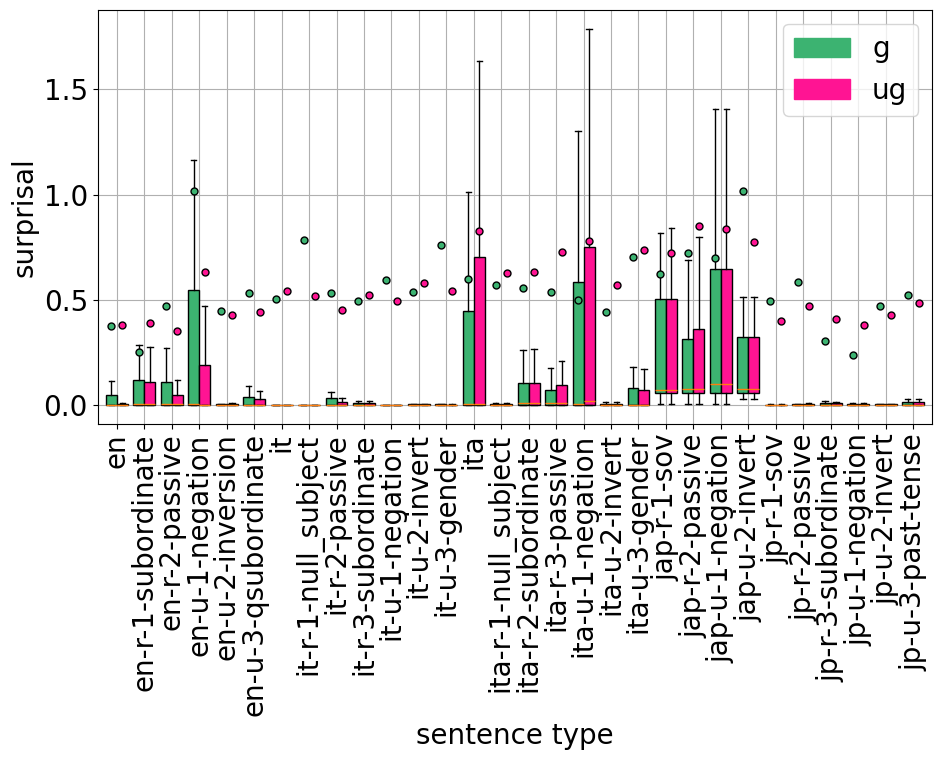

In [144]:
x = []
y = []
x_ug = []
y_ug = []

sfig, ax = plt.subplots(figsize=(10, 8))

for sent_type in sorted(f['type'].unique()):
    surps = []
    for idx, row in f[(f['type'] == sent_type) & (f['gold'] == 'Yes')].iterrows():
        myList = []
        for i in list(ast.literal_eval(row['surprisal'])):
            myList.append(i[1])
        surps.append(myList)
    avg_surp = np.array([i for m in surps for i in m])
    font = {'family' : 'sans-serif',
            'weight' : 'normal',
            'size'   : 20}

    x.append(f'{sent_type}')
    y.append(sorted(avg_surp))

    for idx, row in f[(f['type'] == sent_type) & (f['gold'] == 'No')].iterrows():
        myList = []
        for i in list(ast.literal_eval(row['surprisal'])):
            myList.append(i[1])
        surps.append(myList)
    avg_surp = np.array([i for m in surps for i in m])
    font = {'family' : 'sans-serif',
            'weight' : 'normal',
            'size'   : 20}

    x_ug.append(f'{sent_type}')
    y_ug.append(sorted(avg_surp))

plt.grid()
matplotlib.rc('font', **font)

positions = np.arange(1, len(x) + 1)

for i in range(len(x)):
    bp = plt.boxplot([y[i], y_ug[i]], positions=[positions[i], positions[i] + 0.4], 
                widths=0.4, autorange=True, patch_artist=True, showfliers=False, vert=True, showmeans=True)
    for patch, color in zip(bp['boxes'], ['mediumseagreen', 'deeppink']):
        patch.set_facecolor(color)

    for mean, color in zip([bp['means'][0], bp['means'][1]], ['mediumseagreen', 'deeppink']):
        mean.set(markerfacecolor=color, marker='o', markersize=5, markeredgecolor="black")
# bplot1 = plt.boxplot(y, autorange=True, patch_artist=True, showfliers=False, vert=True, showmeans=True, labels=x)
# bplot2 = plt.boxplot(y_ug, autorange=True, vert=True, patch_artist=True, showfliers=False, showmeans=True, labels=x_ug, meanprops={"markerfacecolor":"white", "markeredgecolor":"blue"})
for patch in bplot1['boxes']:
    patch.set_facecolor('mediumseagreen')

for patch in bplot1['boxes']:
    patch.set_facecolor('deeppink')
    
plt.xlabel("sentence type")
plt.xticks(positions + 0.2, x, rotation=90)
plt.ylabel("surprisal")
legend_handles = [plt.Rectangle((0,0),1,1, color='mediumseagreen'), plt.Rectangle((0,0),1,1, color='deeppink')]
plt.legend(legend_handles, ['g', 'ug'], loc='upper right')

sfig.tight_layout()
sfig.savefig('/home/gridsan/arunas/broca/llama/experiments/llama-surprisals.png')
plt.show()